<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Sentiment Analysis 💬</h1></center>


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Import & Load Data</h1>

In [1]:
# pip install twython 
# pip install vaderSentiment
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical # One-hot encode the multi-class labels
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import  pipeline
import torch
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [2]:
df = pd.read_csv('Corona.csv', header = 0, encoding = 'cp437')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
columns_to_keep = ['OriginalTweet', 'Sentiment'] 
df = df[columns_to_keep]
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">EDA</h1>

In [4]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [5]:
df['OriginalTweet'].tolist()[:10]

['@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
 'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
 'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
 "My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",
 "Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thin

In [6]:
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Feature Engineering</h1>


---

### Approach:

We will work on two scenarios:

1. **Binary Classification**:
   - We will transform the values as follows:
     - 'Positive' and 'Extremely Positive' will be converted to **1**.
     - All other values will be converted to **0**.
   - The transformed values will be saved in the `BCategory` column.

2. **Multi-Class Classification**:
   - We will map each category to a number, as follows:
     - 'Positive' → **0**
     - 'Negative' → **1**
     - 'Neutral' → **2**
     - 'Extremely Positive' → **3**
     - 'Extremely Negative' → **4**
   - The transformed values will be saved in the `MCategory` column.

We will then apply models to both cases and analyze which approach is more suitable for our use case.

---

In [7]:
def BClass(x) :
  if x in ['Positive','Extremely Positive'] :
    return 1
  else :
    return 0
df['BCategory'] = df['Sentiment'].apply(lambda x : BClass(x))
df['BCategory'].value_counts()

BCategory
0    23111
1    18046
Name: count, dtype: int64

In [8]:
Labels= {'Extremely Positive':0,'Positive':1,'Neutral':2,'Negative':3,'Extremely Negative':4}
df['MCategory'] = df['Sentiment'].map(Labels)
df['MCategory'] .value_counts()

MCategory
1    11422
3     9917
2     7713
0     6624
4     5481
Name: count, dtype: int64

In [9]:
df.head()

,OriginalTweet,Sentiment,BCategory,MCategory
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,2
1,advice Talk to your neighbours family to excha...,Positive,1,1
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,1
3,My food stock is not the only one which is emp...,Positive,1,1
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,4


In [10]:
df['TLength'] = df['OriginalTweet'].apply(lambda x : len(x))
df['SentenceLength'] = df['OriginalTweet'].apply(lambda x : len(x.split()))
df.head()

,OriginalTweet,Sentiment,BCategory,MCategory,TLength,SentenceLength
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,2,111,8
1,advice Talk to your neighbours family to excha...,Positive,1,1,237,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,1,131,14
3,My food stock is not the only one which is emp...,Positive,1,1,306,42
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,4,310,40



---

I have modified the stop words in **NLTK** to better align with our use case. Specifically, I have ensured that certain words, such as "Don't" and "Haven't," are not removed from the tweets, as they carry important sentiment information.

--- 


In [11]:
# our custom stop words set
custom_stop_words = {
    'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am',
    'an', 'and', 'any', 'as', 'at', 'be', 'because',
    'been', 'before', 'being', 'below', 'between', 'both', 'by',
    'can', 'do', 'does', 'doing', 'down', 'during', 'each',
    'few', 'for', 'from', 'further', 'had', 'has', 'hasn',
    'have', 'having', 'he', 'her', 'here', 'hers', 'herself',
    'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is',
    'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me',
    'more', 'most', 'my', 'myself', 'no', 'nor',
    'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other',
    'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's',
    'same', 'she', "she's", 'should', "should've", 'so', 'some',
    'such', 't', 'than', 'that', "that'll", 'the', 'their',
    'theirs', 'them', 'themselves', 'then', 'there', 'these',
    'they', 'this', 'those', 'through', 'to', 'too', 'under',
    'until', 'up', 've', 'very', 'was', 'wasn', 'we',
    'were', 'what', 'when', 'where', 'which', 'while', 'who',
    'whom', 'why', 'will', 'with', 'y', 'you',
    "you'd", "you'll", "you're", "you've", 'your', 'yours',
    'yourself', 'yourselves', 'amp','are','onlin'
}

In [12]:
stemmer = PorterStemmer()

def clean_and_remove_stop_words(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)  # Remove anything within square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text.strip())  # Remove extra whitespaces
    text = re.sub('<.*?>+', '', text)  # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)  # Remove newlines
    text = re.sub('\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = " ".join(text.split())  # Normalize spacing
    
    tokens = word_tokenize(text)
    
    cleaned_tokens = [
        stemmer.stem(token) for token in tokens
        if token not in custom_stop_words and token.isalpha()
    ]
    
    cleaned_text = ' '.join(cleaned_tokens)  
    return cleaned_text

df["Cleaned_Tweet"] = df["OriginalTweet"].apply(clean_and_remove_stop_words)
df.head()

,OriginalTweet,Sentiment,BCategory,MCategory,TLength,SentenceLength,Cleaned_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,2,111,8,menyrbi philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,1,1,237,38,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,1,131,14,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,1,1,306,42,food stock not one empti pleas dont panic enou...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,4,310,40,readi go supermarket outbreak not im paranoid ...


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Visualization </h1>


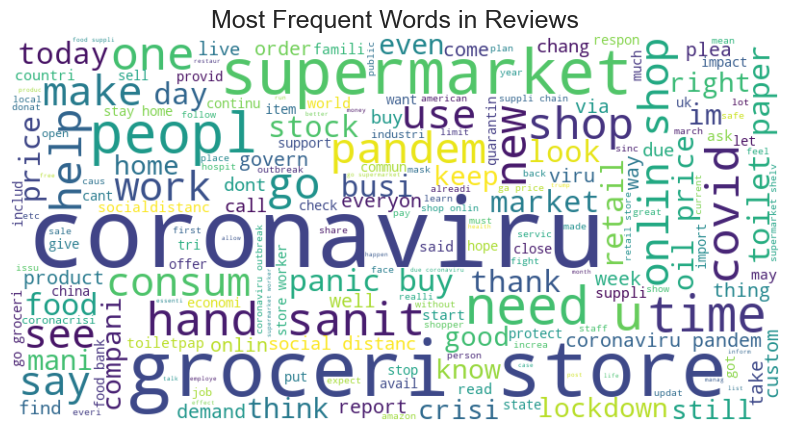

In [276]:
# Join all the reviews into one large string
text = " ".join(review for review in df['Cleaned_Tweet'])

wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Reviews", fontsize=18)
plt.show()

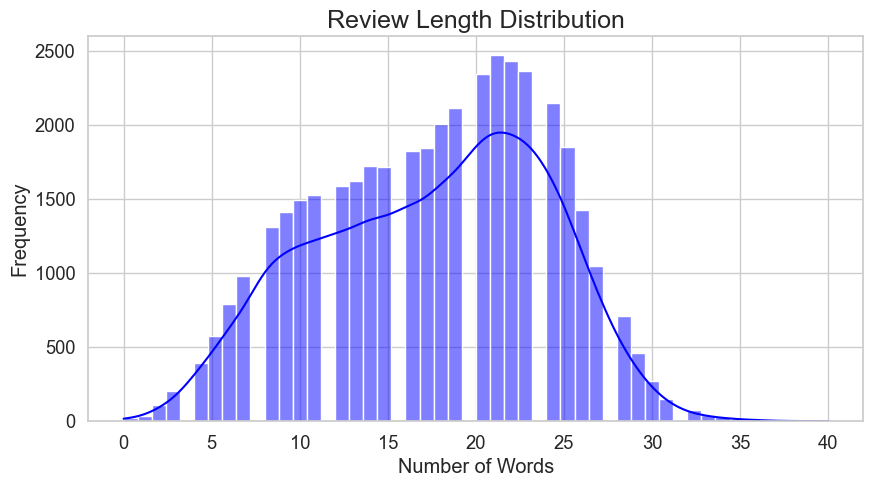

In [301]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Cleaned_Tweet'].apply(lambda x: len(x.split())), bins=50, kde=True, color='blue')
plt.title("Review Length Distribution", fontsize=18)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

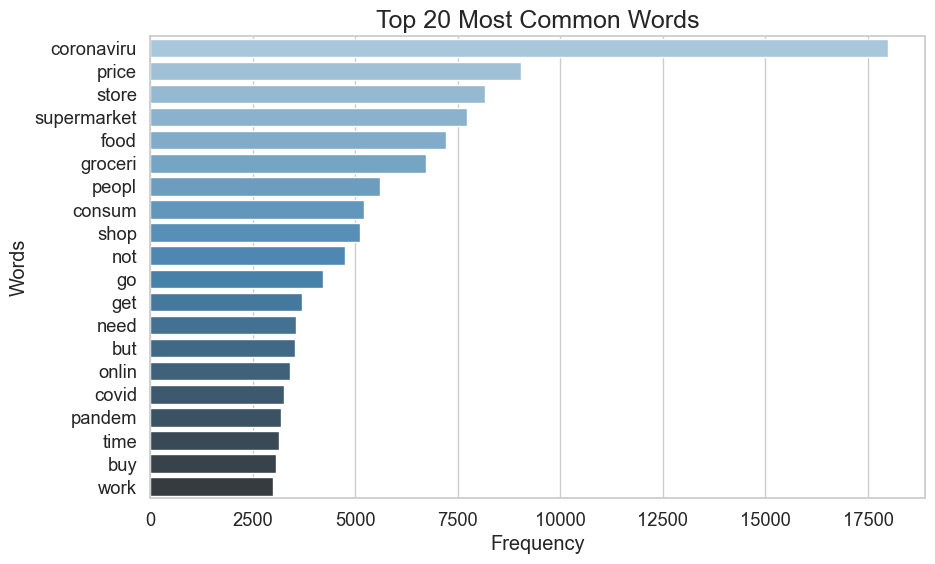

In [302]:
all_words = ' '.join(df['Cleaned_Tweet']).split()
word_freq = Counter(all_words)
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False).head(20)

# Plot the top 20 most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=word_freq_df, palette='Blues_d')
plt.title("Top 20 Most Common Words", fontsize=18)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [303]:
df.head()

,OriginalTweet,Sentiment,BCategory,MCategory,TLength,SentenceLength,Cleaned_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,2,111,8,menyrbi philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,1,1,237,38,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,1,131,14,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,1,1,306,42,food stock not one empti pleas dont panic enou...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,4,310,40,readi go supermarket outbreak not im paranoid ...


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Custom Models training (Binary Case) </h1>

In [13]:
X = df[['Cleaned_Tweet']]
y = df['BCategory']

In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Cleaned_Tweet'])
y = df['BCategory']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [338]:
results = []

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)), 
    ('Naive Bayes', MultinomialNB()),
    ('SVM', SVC()),  
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=80)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=.1)),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.9)),
    ('Extra Trees', ExtraTreeClassifier(max_depth=12, min_samples_split=10))
]

def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)  
    results.append([model_name, accuracy])

for model_name, model in models:
    evaluate_model(model, model_name)

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df

,Model,Accuracy
0,Logistic Regression,0.835884
1,Naive Bayes,0.758260
2,SVM,0.841351
3,Random Forest,0.601069
4,Decision Tree,0.774295
5,AdaBoost,0.706876
6,XGBoost,0.813654
7,Gradient Boosting,0.776118
8,Extra Trees,0.576045


In [16]:
SVC = SVC()
SVC.fit(X_train, y_train)
y_pred = SVC.predict(X_test)
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      4615
           1       0.87      0.75      0.81      3617

    accuracy                           0.84      8232
   macro avg       0.85      0.83      0.84      8232
weighted avg       0.84      0.84      0.84      8232



<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Custom Models training (Multi Case) </h1>

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Cleaned_Tweet']) 
y = df['MCategory']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [339]:
results = []

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)), 
    ('Naive Bayes', MultinomialNB()),
    ('SVM', SVC(probability=True)),  
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=80)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=.1)),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),  
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.9))
]

def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test) 
    results.append([model_name, accuracy])

for model_name, model in models:
    evaluate_model(model, model_name)

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df

,Model,Accuracy
0,Logistic Regression,0.574344
1,Naive Bayes,0.375486
2,SVM,0.594874
3,Random Forest,0.293853
4,Decision Tree,0.450802
5,AdaBoost,0.355685
6,XGBoost,0.562439
7,Gradient Boosting,0.512148


In [70]:
columns_to_keep = ['Cleaned_Tweet', 'Sentiment', 'BCategory', 'MCategory']
df = df[columns_to_keep]
df.head()

,Cleaned_Tweet,Sentiment,BCategory,MCategory
0,menyrbi philgahan chrisitv,Neutral,0,2
1,advic talk neighbour famili exchang phone numb...,Positive,1,1
2,coronaviru australia woolworth give elderli di...,Positive,1,1
3,food stock not one empti pleas dont panic enou...,Positive,1,1
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> NLTK's VADER </h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Binary Case</h3>


In [72]:
sia = SentimentIntensityAnalyzer()

# Apply VADER to calculate compound sentiment score (-1 to 1)
df['Sentiment_Score_Binary'] = df['Cleaned_Tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Define binary classification based on VADER score (Positive/Negative)
def binary_classification(score):
    return 1 if score >= 0 else 0  # Positive (1) if score >= 0, Negative (0) otherwise

# binary classification
df['BSentiment'] = df['Sentiment_Score_Binary'].apply(binary_classification)

# accuracy 
binary_accuracy = accuracy_score(df['BCategory'], df['BSentiment'])
print(f'Binary Classification Accuracy: {binary_accuracy * 100:.2f}%')
df.head()

Binary Classification Accuracy: 66.72%


,Cleaned_Tweet,Sentiment,BCategory,MCategory,Sentiment_Score_Binary,BSentiment
0,menyrbi philgahan chrisitv,Neutral,0,2,0.0000,1
1,advic talk neighbour famili exchang phone numb...,Positive,1,1,0.0772,1
2,coronaviru australia woolworth give elderli di...,Positive,1,1,0.0000,1
3,food stock not one empti pleas dont panic enou...,Positive,1,1,0.7847,1
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4,0.6024,1


<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Multi Class</h3>


In [74]:
df['Sentiment_Score_Multi'] = df['Cleaned_Tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Map the compound score from (-1, 1) to (0, 5)
df['Sentiment_Multi'] = df['Sentiment_Score_Multi'].apply(lambda score: ((score + 1) / 2) * 5)

# Define function to map continuous sentiment score (0-5) to ordinal categories (0 to 4)
def map_sentiment_to_category(score):
    if score <= 1:  # Extremely Negative
        return 0
    elif 1 < score <= 2:  # Negative
        return 1
    elif 2 < score <= 3:  # Neutral
        return 2
    elif 3 < score <= 4:  # Positive
        return 3
    else:  # Extremely Positive
        return 4

# Apply the mapping function to get multi-class prediction
df['MSentiment'] = df['Sentiment_Multi'].apply(map_sentiment_to_category)

# Compute accuracy for multi-class classification
multi_class_accuracy = accuracy_score(df['MCategory'], df['MSentiment'])
print(f'Multi-Class Classification Accuracy: {multi_class_accuracy * 100:.2f}%')
df.head()

Multi-Class Classification Accuracy: 20.83%


,Cleaned_Tweet,Sentiment,BCategory,MCategory,Sentiment_Score_Binary,BSentiment,Sentiment_Score_Multi,Sentiment_Multi,MSentiment
0,menyrbi philgahan chrisitv,Neutral,0,2,0.0000,1,0.0000,2.50000,2
1,advic talk neighbour famili exchang phone numb...,Positive,1,1,0.0772,1,0.0772,2.69300,2
2,coronaviru australia woolworth give elderli di...,Positive,1,1,0.0000,1,0.0000,2.50000,2
3,food stock not one empti pleas dont panic enou...,Positive,1,1,0.7847,1,0.7847,4.46175,4
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4,0.6024,1,0.6024,4.00600,4


In [75]:
columns_to_keep = ['Cleaned_Tweet', 'Sentiment', 'BCategory', 'MCategory','BSentiment','MSentiment']
df = df[columns_to_keep]
df.head()

,Cleaned_Tweet,Sentiment,BCategory,MCategory,BSentiment,MSentiment
0,menyrbi philgahan chrisitv,Neutral,0,2,1,2
1,advic talk neighbour famili exchang phone numb...,Positive,1,1,1,2
2,coronaviru australia woolworth give elderli di...,Positive,1,1,1,2
3,food stock not one empti pleas dont panic enou...,Positive,1,1,1,4
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4,1,4


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Transformers</h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Binary Case</h3>

In [76]:
# Load pre-trained sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Apply the pipeline to each tweet to get sentiment (POSITIVE or NEGATIVE) and confidence score
df['Sentiment_Pipeline_Binary'] = df['Cleaned_Tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Convert the sentiment labels from the pipeline to binary values (1 for POSITIVE, 0 for NEGATIVE)
df['Predicted_Sentiment_Binary'] = df['Sentiment_Pipeline_Binary'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Compute the accuracy for binary classification
binary_accuracy_pipeline = accuracy_score(df['BCategory'], df['Predicted_Sentiment_Binary'])
print(f'Binary Classification Accuracy using Hugging Face Pipeline: {binary_accuracy_pipeline * 100:.2f}%')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy using Hugging Face Pipeline: 58.63%


<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Multi Case</h3>

In [77]:
# Function to map confidence score to the multi-class range (0-5 mapped to 0-4 for MCategory)
def map_pipeline_to_multi_class(score):
    if score <= 0.2:  # Extremely Negative
        return 0
    elif 0.2 < score <= 0.4:  # Negative
        return 1
    elif 0.4 < score <= 0.6:  # Neutral
        return 2
    elif 0.6 < score <= 0.8:  # Positive
        return 3
    else:  # Extremely Positive
        return 4

# Apply the pipeline and get the compound score
df['Sentiment_Pipeline_Multi'] = df['Cleaned_Tweet'].apply(lambda x: sentiment_pipeline(x)[0]['score'])

# Map the pipeline score (0-1) to the 0-4 range
df['Predicted_Sentiment_Multi'] = df['Sentiment_Pipeline_Multi'].apply(map_pipeline_to_multi_class)

# Compute the accuracy for multi-class classification
multi_class_accuracy_pipeline = accuracy_score(df['MCategory'], df['Predicted_Sentiment_Multi'])
print(f'Multi-Class Classification Accuracy using Hugging Face Pipeline: {multi_class_accuracy_pipeline * 100:.2f}%')
df.head()

Multi-Class Classification Accuracy using Hugging Face Pipeline: 13.73%


,Cleaned_Tweet,Sentiment,BCategory,MCategory,BSentiment,MSentiment,Sentiment_Pipeline_Binary,Predicted_Sentiment_Binary,Sentiment_Pipeline_Multi,Predicted_Sentiment_Multi
0,menyrbi philgahan chrisitv,Neutral,0,2,1,2,POSITIVE,1,0.984861,4
1,advic talk neighbour famili exchang phone numb...,Positive,1,1,1,2,NEGATIVE,0,0.996785,4
2,coronaviru australia woolworth give elderli di...,Positive,1,1,1,2,NEGATIVE,0,0.986887,4
3,food stock not one empti pleas dont panic enou...,Positive,1,1,1,4,NEGATIVE,0,0.985384,4
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4,1,4,NEGATIVE,0,0.994598,4


In [78]:
df['Sentiment_Pipeline_Binary'] = df['Sentiment_Pipeline_Binary'].map({'POSITIVE': 1, 'NEGATIVE': 0})
columns_to_keep = ['Cleaned_Tweet', 'Sentiment', 'BCategory', 'MCategory','BSentiment','MSentiment','Sentiment_Pipeline_Binary','Predicted_Sentiment_Multi']
df = df[columns_to_keep]
df.head()

,Cleaned_Tweet,Sentiment,BCategory,MCategory,BSentiment,MSentiment,Sentiment_Pipeline_Binary,Predicted_Sentiment_Multi
0,menyrbi philgahan chrisitv,Neutral,0,2,1,2,1,4
1,advic talk neighbour famili exchang phone numb...,Positive,1,1,1,2,0,4
2,coronaviru australia woolworth give elderli di...,Positive,1,1,1,2,0,4
3,food stock not one empti pleas dont panic enou...,Positive,1,1,1,4,0,4
4,readi go supermarket outbreak not im paranoid ...,Extremely Negative,0,4,1,4,0,4


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">LSTM</h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Binary Case</h3>

In [79]:
# Define parameters
vocab_size = 10000
max_length = 100
embedding_dim = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"

# Tokenize and pad the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['Cleaned_Tweet'])
sequences = tokenizer.texts_to_sequences(df['Cleaned_Tweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Binary classification labels (0 and 1)
y_binary = df['BCategory']

# Split the data into training and test sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(padded_sequences, y_binary, test_size=0.2, random_state=42)

# Define the LSTM model for binary classification
model_binary = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model_binary.fit(X_train_bin, y_train_bin, epochs=5, batch_size=64, validation_data=(X_test_bin, y_test_bin))

y_pred_bin = (model_binary.predict(X_test_bin) > 0.5).astype("int32")
binary_accuracy_lstm = accuracy_score(y_test_bin, y_pred_bin)
print(f'Binary Classification Accuracy with LSTM: {binary_accuracy_lstm * 100:.2f}%')



Epoch 1/5


515/515 [==============================] - 87s 160ms/step - loss: 0.6862 - accuracy: 0.5618 - val_loss: 0.6870 - val_accuracy: 0.5606
Epoch 2/5
515/515 [==============================] - 80s 155ms/step - loss: 0.6858 - accuracy: 0.5618 - val_loss: 0.6858 - val_accuracy: 0.5606
Epoch 3/5
515/515 [==============================] - 80s 155ms/step - loss: 0.6857 - accuracy: 0.5618 - val_loss: 0.6858 - val_accuracy: 0.5606
Epoch 4/5
515/515 [==============================] - 80s 155ms/step - loss: 0.6856 - accuracy: 0.5618 - val_loss: 0.6859 - val_accuracy: 0.5606
Epoch 5/5
258/258 [==============================] - 9s 32ms/step
Binary Classification Accuracy with LSTM: 56.06%


In [80]:
# Multi-class classification labels (0, 1, 2, 3, 4)
y_multi = df['MCategory']

y_multi_encoded = to_categorical(y_multi, num_classes=5)

# Split the data into training and test sets for multi-class classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(padded_sequences, y_multi_encoded, test_size=0.2, random_state=42)

# Define the LSTM model for multi-class classification
model_multi = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # Softmax for multi classification
])

model_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_multi.fit(X_train_multi, y_train_multi, epochs=10, batch_size=64, validation_data=(X_test_multi, y_test_multi))

y_pred_multi = np.argmax(model_multi.predict(X_test_multi), axis=-1)
y_test_multi_labels = np.argmax(y_test_multi, axis=-1)

multi_class_accuracy_lstm = accuracy_score(y_test_multi_labels, y_pred_multi)
print(f'Multi-Class Classification Accuracy with LSTM: {multi_class_accuracy_lstm * 100:.2f}%')

Epoch 1/10
515/515 [==============================] - 94s 176ms/step - loss: 1.5776 - accuracy: 0.2768 - val_loss: 1.5731 - val_accuracy: 0.2778
Epoch 2/10
515/515 [==============================] - 83s 161ms/step - loss: 1.5763 - accuracy: 0.2774 - val_loss: 1.5753 - val_accuracy: 0.2778
Epoch 3/10
515/515 [==============================] - 90s 176ms/step - loss: 1.5762 - accuracy: 0.2774 - val_loss: 1.5727 - val_accuracy: 0.2778
Epoch 4/10
515/515 [==============================] - 98s 190ms/step - loss: 1.5761 - accuracy: 0.2774 - val_loss: 1.5727 - val_accuracy: 0.2778
Epoch 5/10
515/515 [==============================] - 93s 181ms/step - loss: 1.5761 - accuracy: 0.2774 - val_loss: 1.5733 - val_accuracy: 0.2778
Epoch 6/10
515/515 [==============================] - 87s 168ms/step - loss: 1.5760 - accuracy: 0.2774 - val_loss: 1.5726 - val_accuracy: 0.2778
Epoch 7/10
515/515 [==============================] - 80s 156ms/step - loss: 1.5759 - accuracy: 0.2774 - val_loss: 1.5732 - val_ac


---

### Conclusion:

**Binary Classification:**
- The models demonstrated high accuracy, with potential for further improvement. Specifically:
  - **SVM** achieved an accuracy of **85%**.
  - **VADER Sentiment Analysis** yielded an accuracy of **66%**.

**Multi-Class Classification:**
- The models showed lower performance in multi-class problems compared to binary classification:
  - **SVM** achieved an accuracy of **60%**.
  - **Logistic Regression** followed with **58%** accuracy.
  - **LSTM** achieved **57%** accuracy.

Overall, the models performed better in binary classification tasks than in multi-class classification tasks.

---